# Load Dataset


In [ ]:
import os

# Define the folder name
drive_results_path = '/content/drive/MyDrive/FishClassification_Results'

# Create it if it doesn't exist
if not os.path.exists(drive_results_path):
    os.makedirs(drive_results_path)

print("Results will be saved in:", drive_results_path)


Results will be saved in: /content/drive/MyDrive/FishClassification_Results


In [ ]:
!gdown 1e5-wWAXgxs7siSGuv6g5iUCUf--JA_BV

Downloading...
From (original): https://drive.google.com/uc?id=1e5-wWAXgxs7siSGuv6g5iUCUf--JA_BV
From (redirected): https://drive.google.com/uc?id=1e5-wWAXgxs7siSGuv6g5iUCUf--JA_BV&confirm=t&uuid=f0e0daae-01fc-4f3e-aa14-6e539b509921
To: /content/Fish_dataset.zip
100% 1.70G/1.70G [00:15<00:00, 112MB/s]


In [ ]:

# import zipfile
# zf = zipfile.ZipFile('/content/balanced_fish_dataset (1).zip')
# zf.extractall('./new dataset')
# zf.close()

In [ ]:
import zipfile
zf = zipfile.ZipFile('/content/Fish_dataset.zip')
zf.extractall('./Dataset')
zf.close()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib, os, random
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.layers.experimental import preprocessing




# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:

# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2025-04-26 09:53:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-04-26 09:53:56 (64.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# train_dir = "/content/new dataset/train"
# val_dir   = "/content/new dataset/val"
# test_dir  = "/content/new dataset/test"
train_dir = "/content/Dataset/FishImgDataset/train"
val_dir   = "/content/Dataset/FishImgDataset/val"
test_dir  = "/content/Dataset/FishImgDataset/test"

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            label_mode='categorical',
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                 shuffle=True,
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            label_mode='categorical',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 8809 files belonging to 31 classes.
Found 2751 files belonging to 31 classes.
Found 1761 files belonging to 31 classes.


In [ ]:
class_names = train_dataset.class_names
classes = list(train_dataset.class_names)
print('Classes: '+str(classes))
num_classes  = len(classes)
print('Number of classes: '+str(num_classes))

Classes: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']
Number of classes: 31


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import array_to_img

In [ ]:
# Countplot of class distribution
'''labels_list = []
for _, labels in train_dataset.unbatch():
    labels_list.append(tf.argmax(labels).numpy())

plt.figure(figsize=(12, 6))
sns.countplot(x=labels_list)
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=90)
plt.title("Class Distribution in Training Set")
plt.tight_layout()
plt.savefig(os.path.join(drive_results_path, "Countplot.png"))

plt.close()'''

'labels_list = []\nfor _, labels in train_dataset.unbatch():\n    labels_list.append(tf.argmax(labels).numpy())\n\nplt.figure(figsize=(12, 6))\nsns.countplot(x=labels_list)\nplt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=90)\nplt.title("Class Distribution in Training Set")\nplt.tight_layout()\nplt.savefig(os.path.join(drive_results_path, "Countplot.png"))\n\nplt.close()'

In [ ]:
# Show 15 random images from 15 different classes
'''plt.figure(figsize=(15, 10))
class_seen = set()
shown = 0

for image_batch, label_batch in test_dataset.unbatch():
    label_idx = tf.argmax(label_batch).numpy()
    if label_idx not in class_seen:
        plt.subplot(3, 5, shown + 1)
        plt.imshow(array_to_img(image_batch))
        plt.title(class_names[label_idx])
        plt.axis('off')
        shown += 1
        class_seen.add(label_idx)
    if shown >= 15:
        break

plt.tight_layout()
plt.savefig(os.path.join(drive_results_path, "sample_15_images.png"))
plt.close()'''

# Best Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Dense, GlobalAveragePooling2D, DepthwiseConv2D,
    BatchNormalization, Dropout, Activation, Add, Concatenate,
    SpatialDropout2D, RandomFlip, RandomRotation, RandomZoom, RandomContrast
)
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.activations import swish
from tensorflow.keras.metrics import TopKCategoricalAccuracy

# ✅ GhostModule: Lightweight attention block
class Light_weight_attention(tf.keras.layers.Layer):
    def __init__(self, out_channels, ratio=2, activation='relu'):
        super(Light_weight_attention, self).__init__()
        self.out_channels = out_channels
        self.ratio = ratio
        self.activation = activation

    def build(self, input_shape):
        self.primary_channels = self.out_channels // self.ratio
        self.cheap_channels = self.out_channels - self.primary_channels

        self.primary_conv = tf.keras.Sequential([
            Conv2D(self.primary_channels, kernel_size=1, padding='same', use_bias=False),
            BatchNormalization(),
            Activation(self.activation)
        ])
        self.cheap_conv = tf.keras.Sequential([
            DepthwiseConv2D(kernel_size=3, padding='same', use_bias=False),
            BatchNormalization(),
            Activation(self.activation)
        ])

    def call(self, inputs):
        primary = self.primary_conv(inputs)
        cheap = self.cheap_conv(primary)
        return Concatenate()([primary, cheap])



# ✅ Data Augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1)
], name="data_augmentation")

# ✅ Input
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

# ✅ Stem block
# x = conv_stem_block(x) # Remove this line, let MobileNetV3Small handle the initial layers

# ✅ Base Model
base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_tensor=inputs) # Pass the original inputs to MobileNetV3Small

# Unfreeze last 30 layers for fine-tuning
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= len(base_model.layers) - 25


x = Light_weight_attention(out_channels=base_model.output_shape[-1])(base_model.output)

# ✅ Spatial Dropout
x = SpatialDropout2D(0.2)(x)

# ✅ Global Pooling
x = GlobalAveragePooling2D()(x)

# ✅ Residual Dense Block
residual = Dense(64)(x)
x = Dense(64, activation=swish)(x)
x = Dropout(0.2)(x)
x = Add()([x, residual])
x = swish(x)

# ✅ Final Output
outputs = Dense(31, activation='softmax')(x)

# ✅ Model Assembly
model = Model(inputs=inputs, outputs=outputs)

# ✅ Learning Rate Schedule (Cosine Decay)
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    alpha=1e-2  # final_lr = initial_lr * alpha
)

# ✅ Compile Model
top2_acc = TopKCategoricalAccuracy(k=2, name="top_2_accuracy")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy", top2_acc]
)



checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras', monitor='val_loss',
    save_best_only=True, verbose=1
)

# ✅ Optional
# model.summary()

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,185,775 (4.52 MB)

 Trainable params: 735,055 (2.80 MB)

 Non-trainable params: 450,720 (1.72 MB)

In [ ]:
history_fish = model.fit(train_dataset, validation_data=validation_dataset, epochs=50, callbacks=[checkpoint])

Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5086 - loss: 2.1620 - top_2_accuracy: 0.6128
Epoch 1: val_loss improved from inf to 1.46550, saving model to best_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 89s 237ms/step - accuracy: 0.5092 - loss: 2.1602 - top_2_accuracy: 0.6134 - val_accuracy: 0.8502 - val_loss: 1.4655 - val_top_2_accuracy: 0.9204
Epoch 2/50
275/276 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8706 - loss: 1.1157 - top_2_accuracy: 0.9365
Epoch 2: val_loss improved from 1.46550 to 1.08275, saving model to best_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.8707 - loss: 1.1153 - top_2_accuracy: 0.9366 - val_accuracy: 0.9277 - val_loss: 1.0827 - val_top_2_accuracy: 0.9706
Epoch 3/50
275/276 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9442 - loss: 0.9208 - top_2_accuracy: 0.9798
Epoch 3: val_loss improved from 1.08275 to 0.88660, saving model to best_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 43s 157ms/step - accuracy: 0.9442

In [ ]:
score_val_mobilenet = model.evaluate(validation_dataset)

# Print the validation loss and accuracy
print('Validation loss:', score_val_mobilenet[0])
print('Validation accuracy:', score_val_mobilenet[1])

86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9933 - loss: 0.6704 - top_2_accuracy: 0.9968
Validation loss: 0.671363890171051
Validation accuracy: 0.9930934309959412


In [ ]:
score_test_mobilenet = model.evaluate(test_dataset)

# Print the validation loss and accuracy
print('test loss mobilenet:', score_test_mobilenet[0])
print('test accuracy mobilenet:', score_test_mobilenet[1])

56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.9846 - loss: 0.6949 - top_2_accuracy: 0.9929
test loss mobilenet: 0.6993104815483093
test accuracy mobilenet: 0.9846677780151367


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Get class names (optional, if available)
class_names = test_dataset.class_names if hasattr(test_dataset, "class_names") else [str(i) for i in range(31)]

# Get predictions and true labels from test dataset
y_true = []
y_pred_probs = []

for images, labels in test_dataset:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
    preds = model.predict(images)
    y_pred_probs.extend(preds)

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = np.argmax(y_pred_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms

In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      1.00      1.00        43
           2       1.00      0.97      0.99        40
           3       0.94      0.98      0.96        62
           4       1.00      1.00      1.00        30
           5       0.93      0.97      0.95        38
           6       0.96      1.00      0.98        55
           7       1.00      1.00      1.00        77
           8       0.98      0.99      0.98       124
           9       1.00      1.00      1.00        41
          10       1.00      1.00      1.00        63
          11       1.00      0.99      1.00       238
          12       1.00      1.00      1.00        22
          13       1.00      1.00      1.00        53
          14       0.93      1.00      0.96        39
          15       1.00      1.00      1.00        44
          16       0.98      0.98      0.98        58
    

###plot

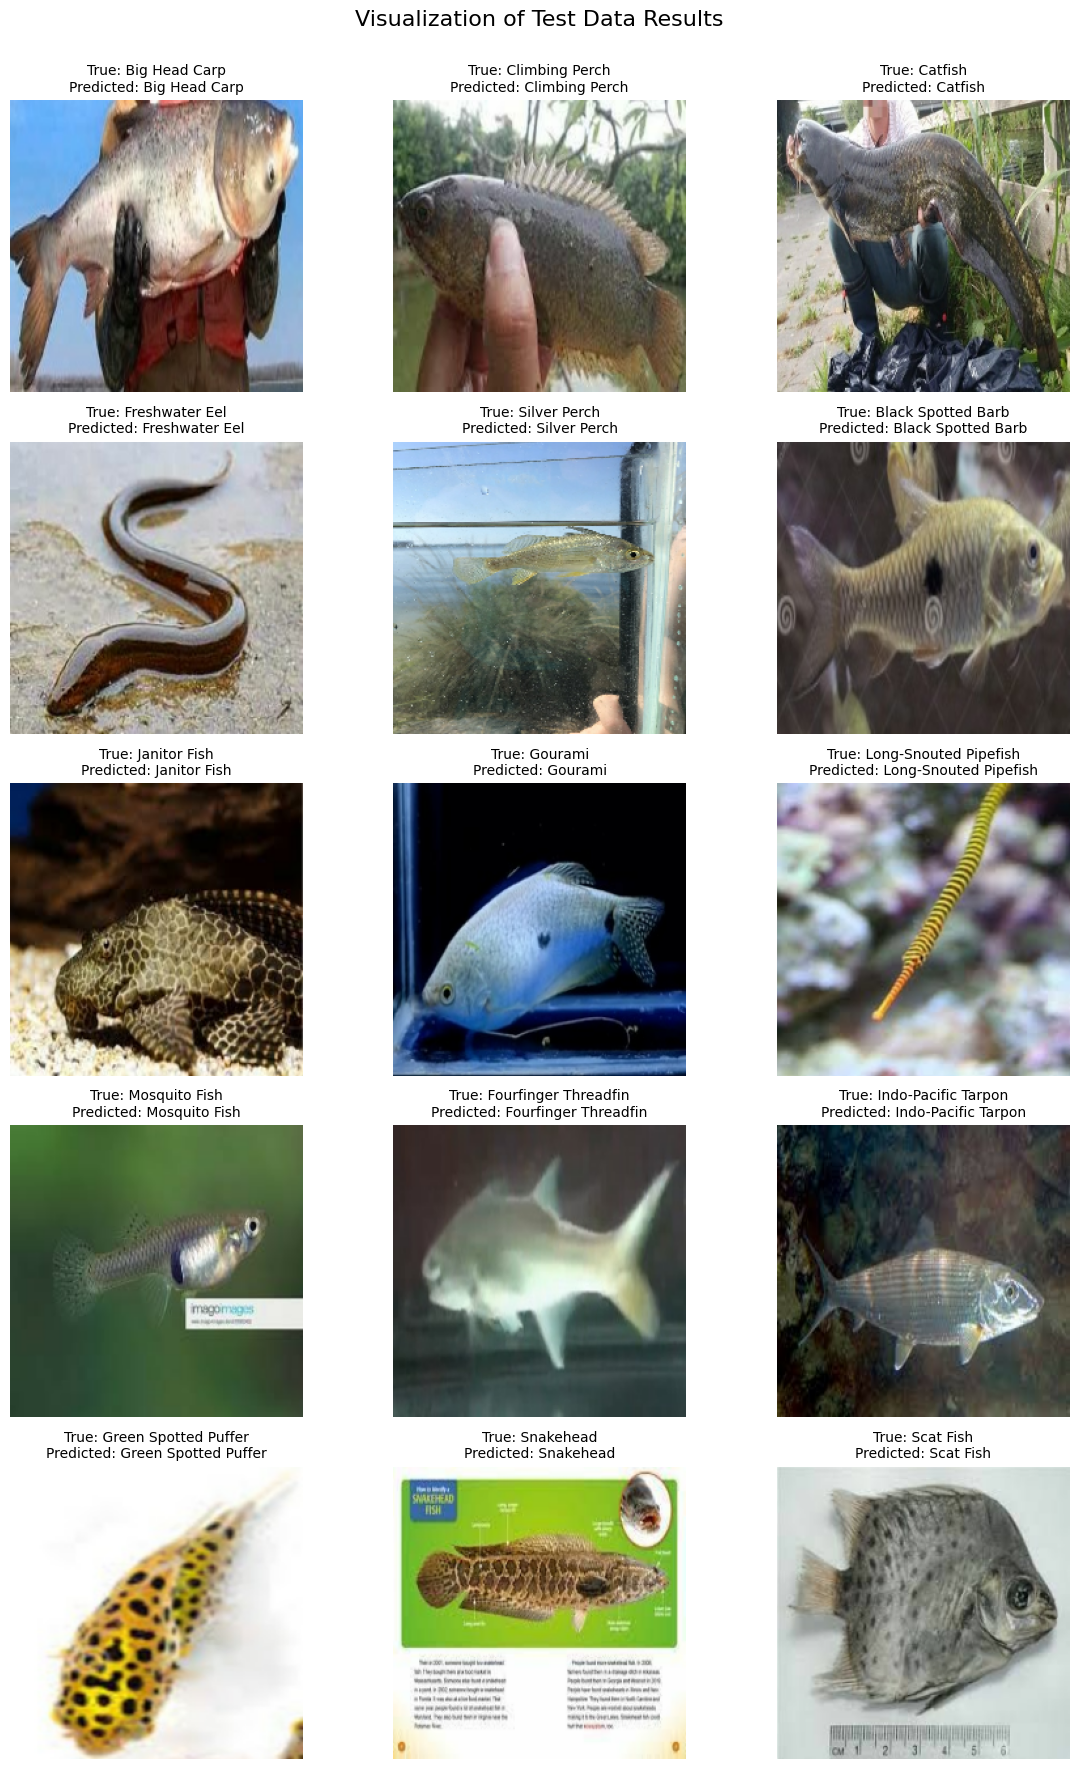

In [ ]:
### random 15 images from test dataset and prediction


import os
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# Instead of using test_dataset.class_names, use the global variable class_names
# Get class names from global variable
# class_names = test_dataset.class_names
class_to_index = {name: i for i, name in enumerate(class_names)}
index_to_class = {i: name for name, i in class_to_index.items()}

# Convert test dataset to numpy arrays for random selection
all_images = []
all_labels = []
for imgs, labels in test_dataset.unbatch():
    all_images.append(imgs)
    all_labels.append(labels)

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Select 15 unique classes
unique_classes = random.sample(class_names, 15)

# Store selected samples
selected_images = []
selected_true_labels = []

# Select one random image from each of the 15 unique classes
for class_name in unique_classes:
    class_idx = class_to_index[class_name]
    indices = np.where(np.argmax(all_labels, axis=1) == class_idx)[0]
    selected_idx = random.choice(indices)
    selected_images.append(all_images[selected_idx])
    selected_true_labels.append(class_name)

# Plot predictions
fig, axes = plt.subplots(5, 3, figsize=(12, 18))
fig.suptitle('Visualization of Test Data Results', fontsize=16)
axes = axes.flatten()

for i in range(15):
    img = tf.expand_dims(selected_images[i], axis=0)
    pred_probs = model.predict(img, verbose=0)
    pred_class = class_names[np.argmax(pred_probs)]

    axes[i].imshow(selected_images[i].astype("uint8"))
    axes[i].set_title(f"True: {selected_true_labels[i]}\nPredicted: {pred_class}", fontsize=10)
    axes[i].axis('off')

# Save and show the figure
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.savefig(os.path.join(drive_results_path, "random_15_class_test_visualization.png"))

plt.show()
plt.close()

In [ ]:
### classification report

import os
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score


# ✅ Evaluate model on test dataset
test_loss, test_accuracy, *_ = model.evaluate(test_dataset, verbose=0)

# ✅ Predict and get labels
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# ✅ Calculate metrics
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

# ✅ Create DataFrame for report
report_df = pd.DataFrame([{
    "Loss": round(test_loss, 4),
    "Accuracy": round(test_accuracy, 4),
    "F1 Score": round(f1, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4)
}])

# ✅ Print report
print("\nPerformance Summary:")
print(report_df.to_string(index=False))

# ✅ Save to CSV in Google Drive
summary_path = os.path.join(drive_results_path, "summary_metrics.csv")
report_df.to_csv(summary_path, index=False)
print(f"\nSaved summary to: {summary_path}")



Performance Summary:
  Loss  Accuracy  F1 Score  Precision  Recall
0.6988    0.9835    0.9817     0.9825  0.9813

Saved summary to: /content/drive/MyDrive/FishClassification_Results/summary_metrics.csv


In [ ]:
### plot_accuracy-loss_curve

import matplotlib.pyplot as plt
import os

# Extract training history
acc = history_fish.history["accuracy"]
val_acc = history_fish.history["val_accuracy"]
loss = history_fish.history["loss"]
val_loss = history_fish.history["val_loss"]
epochs = range(len(acc))

# ✅ Accuracy vs Epoch
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(drive_results_path, "accuracy_vs_epoch.png"))
plt.close()

# ✅ Loss vs Epoch
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(drive_results_path, "loss_vs_epoch.png"))
plt.close()

print("Accuracy and Loss plots saved successfully in:", drive_results_path)


Accuracy and Loss plots saved successfully in: /content/drive/MyDrive/FishClassification_Results


In [ ]:
# ROC curve (multi-class)
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
y_pred_proba = model.predict(test_dataset)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(drive_results_path, "roc_curves.png"))
plt.close()

56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure test labels and predictions are in the correct format
y_true = []
y_pred = []

# Loop through the test dataset
for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
# ✅ Use the globally defined class_names instead of trying to access it from test_dataset
# class_names = test_dataset.class_names
# class_names should already be defined in your code earlier

# Plot and save confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Save to Drive
conf_matrix_path = os.path.join(drive_results_path, "confusion_matrix.png")
plt.savefig(conf_matrix_path)
plt.close()

print("Confusion matrix saved to:", conf_matrix_path)

Confusion matrix saved to: /content/drive/MyDrive/FishClassification_Results/confusion_matrix.png
